<a href="https://colab.research.google.com/github/tyoc213/fastai_xla_extensions/blob/fix_prev_lenet/exploring_freeze_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install fastai2 from github

In [1]:
!pip install -U pandas --upgrade
!pip install -U fastcore --upgrade
!pip install -U fastai --upgrade 

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.1.1)
Requirement already up-to-date: fastcore in /usr/local/lib/python3.6/dist-packages (1.0.0)
Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (2.0.7)


In [2]:
VERSION = "20200707"  #"20200515" @param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5115  100  5115    0     0  43347      0 --:--:-- --:--:-- --:--:-- 43347


In [3]:
#!TORCH_SHOW_CPP_STACKTRACES=1 python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev
!python pytorch-xla-env-setup.py  --version $VERSION --apt-packages libomp5 libopenblas-dev

Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200707 ...
Uninstalling torch-1.7.0a0+12b5bdc:
  Successfully uninstalled torch-1.7.0a0+12b5bdc
Uninstalling torchvision-0.8.0a0+86b6c3e:
  Successfully uninstalled torchvision-0.8.0a0+86b6c3e
Copying gs://tpu-pytorch/wheels/torch-nightly+20200707-cp36-cp36m-linux_x86_64.whl...
- [1 files][107.5 MiB/107.5 MiB]                                                
Operation completed over 1 objects/107.5 MiB.                                    
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200707-cp36-cp36m-linux_x86_64.whl...
| [1 files][123.8 MiB/123.8 MiB]                                                
Operation completed over 1 objects/123.8 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchvision-nightly+20200707-cp36-cp36m-linux_x86_64.whl...
/ [1 files][  2.2 MiB/  2.2 MiB]                                                
Operation completed over 1 objects/2.2 MiB.        

In [4]:
#export
from fastai.callback.core import Callback
from fastai.data.core import DataLoaders
from fastai.vision.all import to_device
from fastai.vision.all import *

#export
class MyXLAOptimProxy:
    "Proxy optimizer to override `opt.step` with Pytorch XLA sync method `xm.optimizer_step` "  
    def __init__(self,opt, barrier=True):
        self.opt = opt
        self._barrier = barrier
        
    def xla_step(self):
        xm.optimizer_step(self.opt,barrier=self._barrier) # sync on gradient update
        
    def __getattr__(self,name):
        if name == 'step': # override proxying for step
            return getattr(self,'xla_step')
        if name in ('barrier','_barrier'):
            return getattr(self,name)

        #print(f'MyXLAOptimProxy#{name}')
        return getattr(self.opt,name)
    @property
    def barrier(self): return self._barrier
    @barrier.setter
    def barrier(self,v): self._barrier = v 
  
class XLAOptCallback(Callback):
    'Callback to replace `opt.step` with `xm.optimizer_step(opt)` as required to run on TPU'
    def __init__(self, barrier=True):
        self._barrier = barrier

    def before_fit(self):
        'replace opt with proxy which calls `xm.optimizer_step` instead of `opt.step` and set `dls.device` and model to `xla_device`'
        to_device(self.dls, device=xm.xla_device())
        self.model.to(self.dls.device)
        if self.learn.opt is not None:
            if not isinstance(self.learn.opt, MyXLAOptimProxy):
                print("MyXLAOptimProxy asign in before_fit from XLAOptCallback\n"*10)
                opt = self.learn.opt
                self.learn.opt = MyXLAOptimProxy(opt, barrier=self._barrier)
                
    def after_fit(self):
        'restore original opt '
        if isinstance(self.learn.opt, MyXLAOptimProxy):
            opt = self.learn.opt.opt
            self.learn.opt = opt
    @property
    def barrier(self): return self._barrier
    @barrier.setter
    def barrier(self,v): self._barrier = v


In [5]:

import torch_xla.core.xla_model as xm
dede = xm.xla_device()

In [6]:
path = untar_data(URLs.MNIST_SAMPLE)
dblock = DataBlock(
    splitter = GrandparentSplitter(),
    item_tfms = Resize(56),
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = parent_label,
    batch_tfms = []
)
dls_tpu = dblock.dataloaders(path, device=dede)
tpu_learner = cnn_learner(dls_tpu, resnet18, metrics=accuracy, cbs=[XLAOptCallback()])
#tpu_learner.summary()
#tpu_learner.show_training_loop()
#tpu_learner.lr_find()
#tpu_learner.dls.device#,tpu_learner.model.parameters().device

MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback



SuggestedLRs(lr_min=2.511886486900039e-06, lr_steep=4.786300905834651e-06)

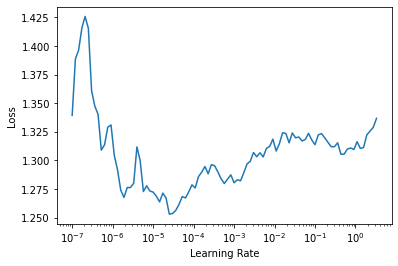

In [7]:
tpu_learner.lr_find()

In [8]:
tpu_learner.fit(4, lr=9.12010818865383e-07)

MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback



epoch,train_loss,valid_loss,accuracy,time
0,1.283183,0.988838,0.498037,00:45
1,1.292144,1.002386,0.474975,00:24
2,1.287234,0.998904,0.485280,00:22
3,1.298177,0.980130,0.495584,00:23


MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback



MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback



epoch,train_loss,valid_loss,accuracy,time
0,1.471159,1.163848,0.454367,00:33
1,1.472113,1.145205,0.457311,00:19
2,1.484353,1.157756,0.452404,00:19
3,1.495891,1.161738,0.453876,00:19


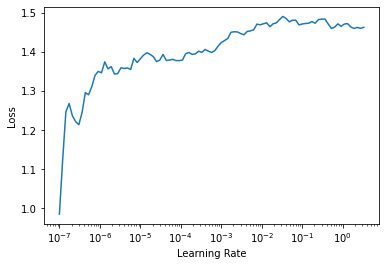

In [9]:
path = untar_data(URLs.MNIST_SAMPLE)
dblock = DataBlock(
    splitter = GrandparentSplitter(),
    item_tfms = Resize(28),
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = parent_label,
    batch_tfms = []
)
dls_tpu2 = dblock.dataloaders(path, device=dede)
tpu_learner2 = cnn_learner(dls_tpu2, resnet18, pretrained=False, metrics=accuracy, cbs=[XLAOptCallback()])
tpu_learner2.lr_find()
tpu_learner2.fit(4, lr=1e-7)

MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback



MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback
MyXLAOptimProxy asign in before_fit from XLAOptCallback



epoch,train_loss,valid_loss,accuracy,time
0,1.360293,0.929623,0.511286,00:33
1,1.312755,0.951045,0.503435,00:19
2,1.335082,0.927400,0.512267,00:19
3,1.333127,0.949498,0.502944,00:19


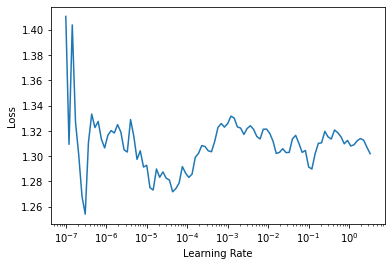

In [10]:
path = untar_data(URLs.MNIST_SAMPLE)
dblock = DataBlock(
    splitter = GrandparentSplitter(),
    item_tfms = Resize(28),
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = parent_label,
    batch_tfms = []
)
dls_tpu3 = dblock.dataloaders(path, device=dede)
tpu_learner3 = cnn_learner(dls_tpu3, resnet18, pretrained=True, metrics=accuracy, cbs=[XLAOptCallback()])
tpu_learner3.lr_find()
tpu_learner3.fit(4, lr=1e-3)

# Manual freeze

In [11]:
#export
from fastai.callback.core import Callback
from fastai.data.core import DataLoaders
from fastai.vision.all import to_device
from fastai.vision.all import *

#export
class MyXLAOptimProxy:
    "Proxy optimizer to override `opt.step` with Pytorch XLA sync method `xm.optimizer_step` "  
    def __init__(self,opt, barrier=True):
        self.opt = opt
        self._barrier = barrier
        
    def xla_step(self):
        xm.optimizer_step(self.opt,barrier=self._barrier) # sync on gradient update
        
    def __getattr__(self,name):
        if name == 'step': # override proxying for step
            return getattr(self,'xla_step')
        if name in ('barrier','_barrier'):
            return getattr(self,name)

        return getattr(self.opt,name)
    @property
    def barrier(self): return self._barrier
    @barrier.setter
    def barrier(self,v): self._barrier = v 
  
class MyXLAOptCallback(Callback):
    'Callback to replace `opt.step` with `xm.optimizer_step(opt)` as required to run on TPU'
    def __init__(self, barrier=True):
        self._barrier = barrier

    def before_fit(self):
        'replace opt with proxy which calls `xm.optimizer_step` instead of `opt.step` and set `dls.device` and model to `xla_device`'
        to_device(self.dls, device=xm.xla_device())
        self.model.to(self.dls.device)
        if self.learn.opt is not None:
            if not isinstance(self.learn.opt, MyXLAOptimProxy):
                print("MyXLAOptimProxy asign in before_fit from MyXLAOptCallback\n"*10)
                opt = self.learn.opt
                self.learn.opt = MyXLAOptimProxy(opt, barrier=self._barrier)
                
    def after_fit(self):
        'restore original opt '
        if isinstance(self.learn.opt, MyXLAOptimProxy):
            opt = self.learn.opt.opt
            self.learn.opt = opt
    @property
    def barrier(self): return self._barrier
    @barrier.setter
    def barrier(self,v): self._barrier = v

path = untar_data(URLs.MNIST_SAMPLE)
dblock = DataBlock(
    splitter = GrandparentSplitter(),
    item_tfms = Resize(28),
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = parent_label,
    batch_tfms = []
)
dls_tpu_manual = dblock.dataloaders(path, device=dede)
# pass false so that we unfreeze manually as in the cnn_learner
tpu_learner_manual = cnn_learner(dls_tpu_manual, resnet18, pretrained=False, metrics=accuracy, cbs=[MyXLAOptCallback()])



# manual freezing!

In [12]:

#####################################################
#####################################################
#####################################################
#####################################################
#####################################################
#####################################################
#####################################################
# like call to learn.freeze() that does freeze_to(-1)
#####################################################
#####################################################
#####################################################
n = -1
if tpu_learner_manual.opt is None:
    print("create opttttttttttttttttttttttttttttttttttttttttt")
    tpu_learner_manual.create_opt()
    print(f'create_opt {tpu_learner_manual.opt}')
    tpu_learner_manual.opt = MyXLAOptimProxy(tpu_learner_manual.opt)
tpu_learner_manual.opt.freeze_to(n)
tpu_learner_manual.opt.clear_state()


create opttttttttttttttttttttttttttttttttttttttttt
create_opt <fastai.optimizer.Optimizer object at 0x7f0344ca7d68>


In [13]:
tpu_learner_manual.dls.device

device(type='xla', index=1)

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=2.0892961401841603e-05)

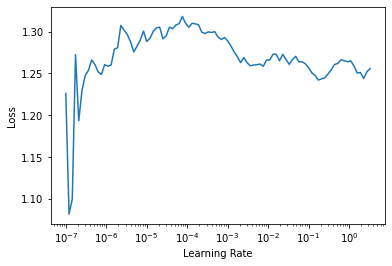

In [14]:
tpu_learner_manual.lr_find()

In [15]:
init = [p.clone() for p in tpu_learner_manual.model.parameters()]

tpu_learner_manual.fit(4, lr=2e-06)
end = [p.clone() for p in tpu_learner_manual.model.parameters()]
for i in range(len(tpu_learner_manual.model)):
  # they seem to print the same!!!!
  print(end[i][:1], end[i][-1:])
  print(init[i][:1], init[i][-1:])

MyXLAOptimProxy asign in before_fit from MyXLAOptCallback
MyXLAOptimProxy asign in before_fit from MyXLAOptCallback
MyXLAOptimProxy asign in before_fit from MyXLAOptCallback
MyXLAOptimProxy asign in before_fit from MyXLAOptCallback
MyXLAOptimProxy asign in before_fit from MyXLAOptCallback
MyXLAOptimProxy asign in before_fit from MyXLAOptCallback
MyXLAOptimProxy asign in before_fit from MyXLAOptCallback
MyXLAOptimProxy asign in before_fit from MyXLAOptCallback
MyXLAOptimProxy asign in before_fit from MyXLAOptCallback
MyXLAOptimProxy asign in before_fit from MyXLAOptCallback



epoch,train_loss,valid_loss,accuracy,time
0,1.261775,0.891863,0.565260,00:24
1,1.284016,0.892756,0.570167,00:19
2,1.286610,0.896700,0.572130,00:19
3,1.250977,0.889644,0.567713,00:19


tensor([[[[ 3.0274e-02,  2.3662e-02,  6.1625e-03, -7.1819e-03,  3.1178e-03,
            2.2259e-02, -1.0388e-02],
          [ 1.0376e-02,  1.4021e-02, -1.2906e-02,  7.1755e-03, -2.3020e-02,
            1.3535e-02,  3.1787e-03],
          [-1.4288e-02,  4.7340e-03,  1.5202e-03,  9.1876e-03,  2.4330e-02,
           -2.4263e-03, -3.0829e-02],
          [-6.9291e-04, -4.4151e-03, -3.2582e-02, -2.0012e-02,  5.8064e-03,
            4.4624e-03,  1.9771e-02],
          [-4.3801e-02,  2.1965e-03, -6.5123e-03, -2.3140e-02,  4.2441e-02,
            6.6365e-03, -1.5309e-02],
          [ 3.4548e-02,  1.8234e-02,  2.7112e-02, -2.9858e-02, -1.4513e-03,
           -1.0586e-02,  2.8342e-02],
          [-1.0626e-02,  2.3720e-03, -2.3262e-02,  2.1117e-02, -1.5652e-02,
            1.3295e-02, -3.4441e-02]],

         [[-1.2875e-02,  4.9325e-02,  2.3618e-02,  1.3809e-02, -3.8302e-02,
           -2.1558e-02,  5.1943e-03],
          [-1.0454e-02, -2.8992e-03, -2.4339e-02, -1.9426e-02, -2.7581e-02,
          

In [16]:
l = zip(init, end)
for x, y in l:
  eq = torch.eq(x==y, torch.ones_like(y)).byte().all()
  print(eq)

tensor(1, device='xla:1', dtype=torch.uint8)
tensor(1, device='xla:1', dtype=torch.uint8)
tensor(1, device='xla:1', dtype=torch.uint8)
tensor(1, device='xla:1', dtype=torch.uint8)
tensor(1, device='xla:1', dtype=torch.uint8)
tensor(1, device='xla:1', dtype=torch.uint8)
tensor(1, device='xla:1', dtype=torch.uint8)
tensor(1, device='xla:1', dtype=torch.uint8)
tensor(1, device='xla:1', dtype=torch.uint8)
tensor(1, device='xla:1', dtype=torch.uint8)
tensor(1, device='xla:1', dtype=torch.uint8)
tensor(1, device='xla:1', dtype=torch.uint8)
tensor(1, device='xla:1', dtype=torch.uint8)
tensor(1, device='xla:1', dtype=torch.uint8)
tensor(1, device='xla:1', dtype=torch.uint8)
tensor(1, device='xla:1', dtype=torch.uint8)
tensor(1, device='xla:1', dtype=torch.uint8)
tensor(1, device='xla:1', dtype=torch.uint8)
tensor(1, device='xla:1', dtype=torch.uint8)
tensor(1, device='xla:1', dtype=torch.uint8)
tensor(1, device='xla:1', dtype=torch.uint8)
tensor(1, device='xla:1', dtype=torch.uint8)
tensor(1, 

In [17]:
# code from https://forums.fast.ai/t/how-can-we-see-what-layers-are-frozen/29318/5?u=tyoc213

def summary_trainable(learner):
  result = []
  total_params_element = 0
  def check_trainable(module):
    nonlocal total_params_element
    if len(list(module.children())) == 0:
      num_param = 0
      num_trainable_param = 0
      num_param_numel = 0
      for parameter in module.parameters():
        num_param += 1
        if parameter.requires_grad:
          num_param_numel += parameter.numel()
          total_params_element += parameter.numel()
          num_trainable_param += 1

      result.append({'module': module, 'num_param': num_param , 'num_trainable_param' : num_trainable_param, 'num_param_numel': num_param_numel})
  learner.model.apply(check_trainable)
  
  print("{: <85} {: <17} {: <20} {: <40}".format('Module Name', 'Total Parameters', 'Trainable Parameters', '# Elements in Trainable Parametrs'))
  for row in result:
    print("{: <85} {: <17} {: <20} {: <40,}".format(row['module'].__str__(), row['num_param'], row['num_trainable_param'], row['num_param_numel']))
  print('Total number of parameters elements {:,}'.format(total_params_element))
print(summary_trainable(tpu_learner_manual))

Module Name                                                                           Total Parameters  Trainable Parameters # Elements in Trainable Parametrs       
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)          1                 0                    0                                       
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)       2                 2                    128                                     
ReLU(inplace=True)                                                                    0                 0                    0                                       
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)            0                 0                    0                                       
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)         1                 0                    0                                       
Batc

In [18]:
path = untar_data(URLs.MNIST_SAMPLE)
dblock = DataBlock(
    splitter = GrandparentSplitter(),
    item_tfms = Resize(28),
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = parent_label,
    batch_tfms = []
)
dlsss = dblock.dataloaders(path, device=dede)
# pass false so that we unfreeze manually as in the cnn_learner
l = cnn_learner(dlsss, resnet18, pretrained=True, metrics=accuracy, cbs=[MyXLAOptCallback()])
print(summary_trainable(l))

Module Name                                                                           Total Parameters  Trainable Parameters # Elements in Trainable Parametrs       
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)          1                 0                    0                                       
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)       2                 2                    128                                     
ReLU(inplace=True)                                                                    0                 0                    0                                       
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)            0                 0                    0                                       
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)         1                 0                    0                                       
Batc

# Comparing output

You can compare output of this 2 summaries of trainable with https://text-compare.com/ the 2 text are identical!!!!

Or save them to var1 and var2 and compare with var1==var2